In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%autosave 0
    
import logging
logging.basicConfig(format='%(asctime)s %(levelname)s:%(message)s', level=logging.DEBUG, datefmt='%I:%M:%S')

import os
import sys
import numpy as np
import pandas as pd
import sdata
import uuid
import time
import copy

#lets find databe.py
modulepath = os.path.dirname(os.getcwd())
sys.path.insert(0, os.path.abspath(os.path.join(modulepath)))

from simple_graph_db import Database

Autosave disabled


05:54:25 DEBUG:Loaded backend module://ipykernel.pylab.backend_inline version unknown.


In [2]:
class Node():
    def __init__(self, name="N.N."):
        self.name = name
        self.uuid = uuid.uuid4().hex
        self.parent = None

    def copy(self, name=None):
        new_node = copy.deepcopy(self)
        new_node.uuid = uuid.uuid4().hex
        new_node.parent = self.uuid
        if name is not None:
            new_node.name = name
        return new_node

    @property
    def data(self):
        return {"name":self.name,
                "uuid":self.uuid,
                "!parent":self.parent}

    def __str__(self):
        return "{0.name}:{0.uuid}".format(self)

    __repr__ = __str__

In [3]:
nodes = []

n0 = Node("n0")
n01 = n0.copy("n01")
n02 = n0.copy("n02")
n011 = n01.copy("n011")
n012 = n01.copy("n012")
print(n0)
print(n01)
nodes.extend([n0, n01, n02, n011, n012])
print(nodes)

n0:ea736302f67a48aab3aa68287a29e17a
n01:01a30c5fd8f340ddaea76fd559862a59
[n0:ea736302f67a48aab3aa68287a29e17a, n01:01a30c5fd8f340ddaea76fd559862a59, n02:dec73de7053647018829bdbd5be7f4a0, n011:99fe995253a6462cab5526eb2334284b, n012:3b883289746f496f808d1442e7d954dd]


## initialize db

In [4]:

db_file = "/tmp/simple_graph_database.sqlite"
if os.path.exists(db_file):
    os.remove(db_file)

db = Database(db_file=db_file)
print(db)

db.add_node(data={"a":1}, identifier=None)

(DB:'/tmp/simple_graph_database.sqlite')


## add nodes

In [5]:
for node in nodes:
    db.add_node(identifier=node.uuid, data=node.data)

In [6]:
db.find_node(node.uuid)

{'name': 'n012',
 'uuid': '3b883289746f496f808d1442e7d954dd',
 '!parent': '01a30c5fd8f340ddaea76fd559862a59',
 'id': '3b883289746f496f808d1442e7d954dd'}

## add edges

In [7]:
for node in nodes:
    if node.parent is not None and node.uuid is not None:
        print("{} -> {}".format(node.parent, node.uuid))
        db.connect_nodes(node.parent, node.uuid, {'parent': node.parent})


ea736302f67a48aab3aa68287a29e17a -> 01a30c5fd8f340ddaea76fd559862a59
ea736302f67a48aab3aa68287a29e17a -> dec73de7053647018829bdbd5be7f4a0
01a30c5fd8f340ddaea76fd559862a59 -> 99fe995253a6462cab5526eb2334284b
01a30c5fd8f340ddaea76fd559862a59 -> 3b883289746f496f808d1442e7d954dd


## get node by uuid

In [8]:
rn0 = db.find_node(n0.uuid)
print(rn0)
assert n0.uuid == rn0.get("uuid")

{'name': 'n0', 'uuid': 'ea736302f67a48aab3aa68287a29e17a', '!parent': None, 'id': 'ea736302f67a48aab3aa68287a29e17a'}


## get all nodes

In [9]:
db.find_nodes({'name': ''})

[{'name': 'n0',
  'uuid': 'ea736302f67a48aab3aa68287a29e17a',
  '!parent': None,
  'id': 'ea736302f67a48aab3aa68287a29e17a'},
 {'name': 'n01',
  'uuid': '01a30c5fd8f340ddaea76fd559862a59',
  '!parent': 'ea736302f67a48aab3aa68287a29e17a',
  'id': '01a30c5fd8f340ddaea76fd559862a59'},
 {'name': 'n02',
  'uuid': 'dec73de7053647018829bdbd5be7f4a0',
  '!parent': 'ea736302f67a48aab3aa68287a29e17a',
  'id': 'dec73de7053647018829bdbd5be7f4a0'},
 {'name': 'n011',
  'uuid': '99fe995253a6462cab5526eb2334284b',
  '!parent': '01a30c5fd8f340ddaea76fd559862a59',
  'id': '99fe995253a6462cab5526eb2334284b'},
 {'name': 'n012',
  'uuid': '3b883289746f496f808d1442e7d954dd',
  '!parent': '01a30c5fd8f340ddaea76fd559862a59',
  'id': '3b883289746f496f808d1442e7d954dd'}]

In [10]:
db.find_nodes({'id': '97'})

[]

In [11]:
rn011 = db.find_node(n011.uuid)
print(rn011)
assert n011.uuid == rn011.get("uuid")
assert n011.parent == rn011.get("!parent")

{'name': 'n011', 'uuid': '99fe995253a6462cab5526eb2334284b', '!parent': '01a30c5fd8f340ddaea76fd559862a59', 'id': '99fe995253a6462cab5526eb2334284b'}


In [12]:
import pygraphviz as pgv
from IPython.display import Image

def draw(dot):
    return Image(pgv.AGraph(dot).draw(format='png', prog='dot'))

In [13]:
ids = [n.uuid for n in nodes]
print(ids)

dotstr = db.get_dot(path=ids)
print("!", dotstr)

['ea736302f67a48aab3aa68287a29e17a', '01a30c5fd8f340ddaea76fd559862a59', 'dec73de7053647018829bdbd5be7f4a0', '99fe995253a6462cab5526eb2334284b', '3b883289746f496f808d1442e7d954dd']
! digraph {
"ea736302f67a48aab3aa68287a29e17a" [label="name n0\nuuid ea736302f67a48aab3aa68287a29e17a\nparent None"];
"ea736302f67a48aab3aa68287a29e17a" -> "01a30c5fd8f340ddaea76fd559862a59" [label=""];
"ea736302f67a48aab3aa68287a29e17a" -> "dec73de7053647018829bdbd5be7f4a0" [label=""];
"01a30c5fd8f340ddaea76fd559862a59" [label="name n01\nuuid 01a30c5fd8f340ddaea76fd559862a59\nparent ea736302f67a48aab3aa68287a29e17a"];
"01a30c5fd8f340ddaea76fd559862a59" -> "99fe995253a6462cab5526eb2334284b" [label=""];
"01a30c5fd8f340ddaea76fd559862a59" -> "3b883289746f496f808d1442e7d954dd" [label=""];
"dec73de7053647018829bdbd5be7f4a0" [label="name n02\nuuid dec73de7053647018829bdbd5be7f4a0\nparent ea736302f67a48aab3aa68287a29e17a"];
"99fe995253a6462cab5526eb2334284b" [label="name n011\nuuid 99fe995253a6462cab5526eb2334284b

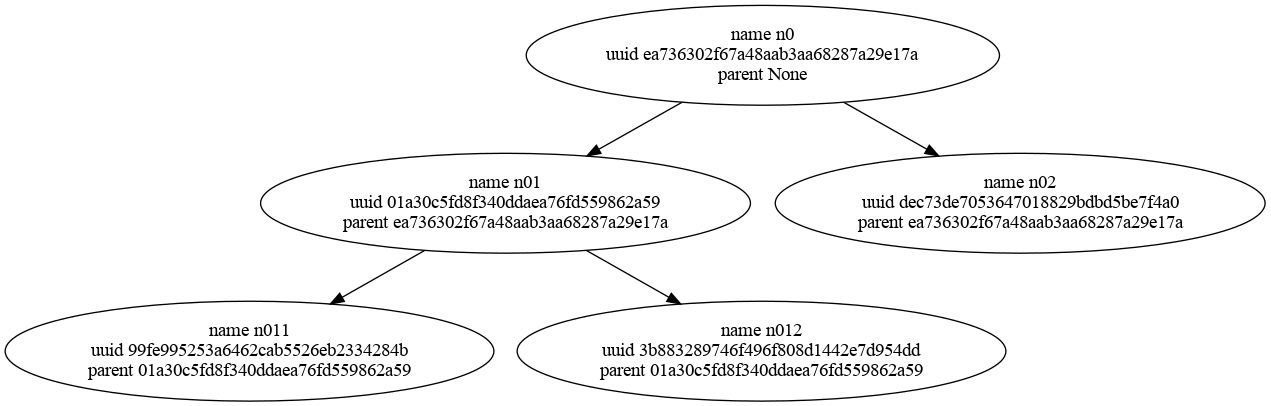

In [14]:
draw(dotstr)


In [15]:
db.visualize(path=ids)

'simple_graph.dot'

In [16]:
cat simple_graph.dot


digraph {
"ea736302f67a48aab3aa68287a29e17a" [label="name n0\nuuid ea736302f67a48aab3aa68287a29e17a\nparent None"];
"01a30c5fd8f340ddaea76fd559862a59" [label="name n01\nuuid 01a30c5fd8f340ddaea76fd559862a59\nparent ea736302f67a48aab3aa68287a29e17a"];
"dec73de7053647018829bdbd5be7f4a0" [label="name n02\nuuid dec73de7053647018829bdbd5be7f4a0\nparent ea736302f67a48aab3aa68287a29e17a"];
"99fe995253a6462cab5526eb2334284b" [label="name n011\nuuid 99fe995253a6462cab5526eb2334284b\nparent 01a30c5fd8f340ddaea76fd559862a59"];
"3b883289746f496f808d1442e7d954dd" [label="name n012\nuuid 3b883289746f496f808d1442e7d954dd\nparent 01a30c5fd8f340ddaea76fd559862a59"];
"ea736302f67a48aab3aa68287a29e17a" -> "01a30c5fd8f340ddaea76fd559862a59" [label="parent ea736302f67a48aab3aa68287a29e17a"];
}


In [17]:
db.find_neighbors(n01.uuid)

[('01a30c5fd8f340ddaea76fd559862a59',
  '99fe995253a6462cab5526eb2334284b',
  '{"parent":"01a30c5fd8f340ddaea76fd559862a59"}'),
 ('01a30c5fd8f340ddaea76fd559862a59',
  '3b883289746f496f808d1442e7d954dd',
  '{"parent":"01a30c5fd8f340ddaea76fd559862a59"}'),
 ('ea736302f67a48aab3aa68287a29e17a',
  '01a30c5fd8f340ddaea76fd559862a59',
  '{"parent":"ea736302f67a48aab3aa68287a29e17a"}')]

In [18]:
db.find_neighbors(n02.uuid)

[('ea736302f67a48aab3aa68287a29e17a',
  'dec73de7053647018829bdbd5be7f4a0',
  '{"parent":"ea736302f67a48aab3aa68287a29e17a"}')]

In [19]:
db.remove_node(n011.uuid)

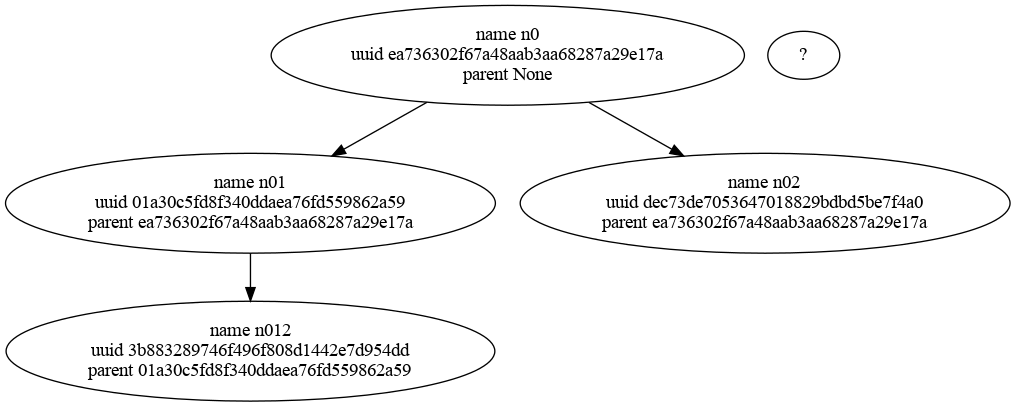

In [20]:
dotstr = db.get_dot(path=ids)
draw(dotstr)